# Analysis of BA-NRMCP using PUCT  for Driving Environment


## Notation

- **Same-play** refers to pairings of policies that are trained together or atleast trained as part of the same population
- **Cross-play** refers to pairings of policies that were not trained together

In [1]:
import sys
import pathlib

# Add ba-posgmcp/experiments/Driving directory to python Path
# So we can import experiment specific code
sys.path.append("/home/jonathon/code/ba-posgmcp/experiments/Driving")

import os.path as osp
from typing import List, Any, Optional, Tuple, Callable
from itertools import permutations, product

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import posggym

import exp_utils
import plot_utils

# Data Loading

## BA-NRMCP Data

In [2]:
ba_results_dir_name = '2022-08-02_banrmcp_puct'

ba_columns_to_drop = [
    "Unnamed: 0",
    'Unnamed: 0.1',
    'Unnamed: 0.2', 
    "args",
    "episode_step_limit",
    "time_limit",
    "use_checkpointing",
    "reinvigoration_time_mean",
    "reinvigoration_time_std",
    "inference_time_mean",
    "inference_time_std",
    "policy_calls_mean",
    "policy_calls_std",
#     "search_time_mean",
#     "search_time_std",
#     "update_time_mean",
#     "update_time_std",
    "episode_returns_mean",
    "episode_returns_std",
    "episode_returns_max",
    "episode_returns_min",
    "episode_discounted_returns_max",
    "episode_discounted_returns_min",
    "episode_dones",
]

ba_df = plot_utils.import_results(ba_results_dir_name, ba_columns_to_drop, True)
plot_utils.validate_and_display(ba_df, True)

ba_only_df = ba_df[ba_df["K"] == "BA"]
print("BA-NRMCP Rollout Policy IDs:", list(ba_only_df["rollout_policy_ids"].unique()))
# Just hardcode it and save parsing
ba_rollout_policy_ids = ['pi_0', 'pi_1', 'pi_2', 'pi_3', 'pi_4']
ba_rollout_Ks = ["0", "1", "2", "3", "4"]

Agent IDs: [0 1]
Test Env: Driving7x7RoundAbout-v0
Seeds: [0 1 2 3]
Policy K: ['-1' '0' '1' '2' '3' '4' 'BA' 'BR']
Policy Names: ['BAPOSGMCP_0' 'PPOPolicy_pi_0' 'PPOPolicy_pi_1' 'PPOPolicy_pi_2'
 'PPOPolicy_pi_3' 'PPOPolicy_pi_4' 'PPOPolicy_pi_BR' 'RandomPolicy']
Coplayer Policy K: ['-1' '0' '1' '2' '3' '4' 'BA' 'BR']
Coplayer Train Seed: [2 'None' 1 3 0 4]
Num rows/entries: 2520
Num experiments: 1260

BAPOSGMCP Hyperparameters
Num sims: ['1024' '128' '2048' '32' '512' '8']
Rollout Policy K: ['BR']
Rollout Policy IDs: ['pi_BR']
Rollout Policy Seeds: [0 1 3]
Rollout Policy Algs: ['klr']
Other Agent Policy Algs: ['klr']
Other Agent Policy Seeds: [0 1 3]
other_policy_prior: None
truncated: True
c_init: 1.25
c_base: 20000.0
reinvigorator: <baposgmcp.tree.reinvigorate.BABeliefRejectionSampler object at 0x7f202024d190> + other values
extra_particles_prop: 0.0625
step_limit: 50
epsilon: 0.01
BA-NRMCP Rollout Policy IDs: ["['pi_0', 'pi_1', 'pi_2', 'pi_3', 'pi_4']"]


In [3]:
print("Columns:")
for c in ba_df.columns:
    print(c)

Columns:
exp_id
agent_id
env_name
seed
num_episodes
policy_name
other_policy_prior
num_sims
c_init
c_base
truncated
reinvigorator
extra_particles_prop
step_limit
epsilon
policy_id
other_agent_policy_dir
other_agent_policy_ids
rollout_policy_ids
rollout_policy_dir
eval_mode
policy_dir
state_accuracy
state_accuracy_0
state_accuracy_1
state_accuracy_2
state_accuracy_3
state_accuracy_4
state_accuracy_5
state_accuracy_6
state_accuracy_7
state_accuracy_8
state_accuracy_9
state_accuracy_10
state_accuracy_11
state_accuracy_12
state_accuracy_13
state_accuracy_14
state_accuracy_15
state_accuracy_16
state_accuracy_17
state_accuracy_18
state_accuracy_19
state_accuracy_20
state_accuracy_21
state_accuracy_22
state_accuracy_23
state_accuracy_24
state_accuracy_25
state_accuracy_26
state_accuracy_27
state_accuracy_28
state_accuracy_29
state_accuracy_30
state_accuracy_31
state_accuracy_32
state_accuracy_33
state_accuracy_34
state_accuracy_35
state_accuracy_36
state_accuracy_37
state_accuracy_38
state_ac

## RL policies

In [4]:
rl_results_dir = "2022-08-02_banrmcp/pairwise_comparison_initseed0_numseeds1_2022-08-03_03-04-158xauqalb"

columns_to_drop = [
    'Unnamed: 0', 
    'episode_step_limit', 
    'time_limit', 
    'use_checkpointing',
    'search_time_mean', 
    'search_time_std', 
    'update_time_mean', 
    'update_time_std',
    'reinvigoration_time_mean', 
    'reinvigoration_time_std', 
    'policy_calls_mean', 
    'policy_calls_std', 
    'inference_time_mean', 
    'inference_time_std',
    'episode_dones',
]
rl_df = plot_utils.import_results(rl_results_dir, columns_to_drop, False)

# rl_df = rl_df[
#     rl_df["exp_id"].isin(
#         rl_df[
#             (rl_df["K"].isin(ba_df["rollout_K"]))
#             & (rl_df["train_seed"].isin(ba_df["rollout_seed"]))
#             & (rl_df["coplayer_K"].isin(ba_df["coplayer_K"]))
#         ]["exp_id"]
#     )
# ]

rl_df.columns
plot_utils.validate_and_display(rl_df, False)
rl_df

Agent IDs: [0 1]
Test Env: Driving7x7RoundAbout-v0
Seeds: [0]
Policy K: ['-1' '0' '1' '2' '3' '4' 'BR']
Policy Names: ['PPOPolicy_pi_0' 'PPOPolicy_pi_1' 'PPOPolicy_pi_2' 'PPOPolicy_pi_3'
 'PPOPolicy_pi_4' 'PPOPolicy_pi_BR' 'RandomPolicy']
Train Envs:: ['Driving7x7RoundAbout-v0']
Train Seeds: [0 1 2 3 4]
Train Algorithms: ['klr']
Coplayer Policy K: ['-1' '0' '1' '2' '3' '4' 'BR']
Coplayer Train Seed: [0 1 2 3 4]
Num rows/entries: 1470
Num experiments: 735


,exp_id,agent_id,env_name,seed,num_episodes,policy_name,policy_dir,policy_id,eval_mode,search_depth_mean,...,prop_LOSS,prop_DRAW,prop_WIN,prop_NA,K,train_env_name,train_seed,train_alg,coplayer_K,coplayer_train_seed
0,476,0,Driving7x7RoundAbout-v0,0,1000,PPOPolicy_pi_4,train_klr_Driving7x7RoundAbout-v0_k4_seed2_202...,pi_4,True,0.0,...,0.045,0.0,0.955,0.000,4,Driving7x7RoundAbout-v0,2,klr,-1,2
1,476,1,Driving7x7RoundAbout-v0,0,1000,RandomPolicy,train_klr_Driving7x7RoundAbout-v0_k4_seed2_202...,pi_-1,None,0.0,...,0.052,0.0,0.012,0.936,-1,Driving7x7RoundAbout-v0,2,klr,4,2
2,60,0,Driving7x7RoundAbout-v0,0,1000,PPOPolicy_pi_0,train_klr_Driving7x7RoundAbout-v0_k4_seed0_202...,pi_0,True,0.0,...,0.073,0.0,0.841,0.086,0,Driving7x7RoundAbout-v0,0,klr,3,1
3,60,1,Driving7x7RoundAbout-v0,0,1000,PPOPolicy_pi_3,train_klr_Driving7x7RoundAbout-v0_k4_seed1_202...,pi_3,True,0.0,...,0.073,0.0,0.902,0.025,3,Driving7x7RoundAbout-v0,1,klr,0,0
4,300,0,Driving7x7RoundAbout-v0,0,1000,RandomPolicy,train_klr_Driving7x7RoundAbout-v0_k4_seed1_202...,pi_-1,None,0.0,...,0.054,0.0,0.009,0.937,-1,Driving7x7RoundAbout-v0,1,klr,BR,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,51,1,Driving7x7RoundAbout-v0,0,1000,PPOPolicy_pi_1,train_klr_Driving7x7RoundAbout-v0_k4_seed1_202...,pi_1,True,0.0,...,0.107,0.0,0.874,0.019,1,Driving7x7RoundAbout-v0,1,klr,-1,0
1466,269,0,Driving7x7RoundAbout-v0,0,1000,PPOPolicy_pi_2,train_klr_Driving7x7RoundAbout-v0_k4_seed1_202...,pi_2,True,0.0,...,0.178,0.0,0.808,0.014,2,Driving7x7RoundAbout-v0,1,klr,2,1
1467,269,1,Driving7x7RoundAbout-v0,0,1000,PPOPolicy_pi_2,train_klr_Driving7x7RoundAbout-v0_k4_seed1_202...,pi_2,True,0.0,...,0.178,0.0,0.813,0.009,2,Driving7x7RoundAbout-v0,1,klr,2,1
1468,608,0,Driving7x7RoundAbout-v0,0,1000,PPOPolicy_pi_1,train_klr_Driving7x7RoundAbout-v0_k4_seed3_202...,pi_1,True,0.0,...,0.018,0.0,0.974,0.008,1,Driving7x7RoundAbout-v0,3,klr,BR,3


# The environment

Here we can see the layout for the environment. Noting that the start and destination positions for each agent changes each episode. Agents always start in a cell along the bottom or right side of the grid and have a destination in a cell along the top or left side of the grid.  

Agents can observe a rectangular area around their current location that that contains 3 cells in front, 1 behind and 1 cell to each side (total 4x3=12 cells), shown by the highlighted cells in the images. 

## State Space

The state of the environment is defined by the combination of the state of each agent vehicle. 

The state of each agent vehicle is defined by:

1. vehicle (x, y) position, where x, y can both have values from 0, 1, ..., 6 (32 possible positions)
2. direction in (N, E, S, W) (4 possible directions)
3. speed in (REVERSE, STOPPED, FORWARD_SLOW, FAST_FORWARD) (4 possible speeds)
4. destination (x, y) position in ((1, 0), (5, 0), (0, 1), (0, 5)) (4 possible destination positions)
5. whether destination has been reached (True, False) (3 possible truth values for (destination reached, crashed))
6. whether vehicle has crashed (True, False) (see 5)
7. minimum distance reached towards the destination along shortest path in 0, ..., 12 (12 possible distances)

The size of the state space for each vehicle is on the order of: 32×4×4×4×3×12 = 73728 states

Taking the cross-product for two vehicles, accounting for fact the two vehicles cannot have the same position or destinations, we have the total state space size is on the order of 3,949,461,506 or roughly 4x10^9 states

## Action space

Each agent has 5 actions: DO_NOTHING, ACCELERATE, DECELERATE, TURN_RIGHT, TURN_LEFT

## Observation space

Each agent observes:

1. Contents (VEHICLE, WALL, EMPTY, DESTINATION) of the 12 adjacent cells (1 + 3 in front + 1 behind by 3 to each side) (60 possible adjacent observations)
2. vehicle speed (4 possibilities)
3. destination coord (4 possibilities)
4. destination reached (True, False)
5. crashed (True, False) (3 possible truth values for (destination reached, crashed))

The size of the observation for each agent is thus: 48x4x4x3 = 2304.

The possible branching factor, given the environment is deterministic and the maximum non-blocked adjacent cells is 11 is on the around 11, given the other vehicle could be in any one of those 11 free cells.


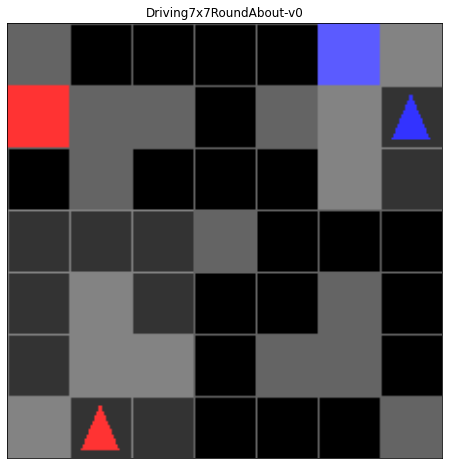

In [5]:
plot_utils.plot_environment(ba_df["env_name"].unique()[0])    
plt.show()

### Helper functions

The next few code blocks contain functions for plotting and cleaning data.

In [6]:
def get_all_mean_rl_pw_values(plot_df, y_key: str):
    row_policy_IDs = plot_df["K"].unique().tolist()
    row_policy_IDs.sort()
    col_policy_IDs = plot_df["coplayer_K"].unique().tolist()
    col_policy_IDs.sort()
    
    xp_pw_returns = np.zeros((len(row_policy_IDs), len(col_policy_IDs)))
    sp_pw_returns = np.zeros((len(row_policy_IDs), len(col_policy_IDs)))

    for r, row_policy_id in enumerate(row_policy_IDs):
        for c, col_policy_id in enumerate(col_policy_IDs):
            sp_return, xp_return = plot_utils.get_mean_pairwise_values(
                plot_df,
                row_conds=[("K", "==", row_policy_id)],
                row_seed_key="train_seed",
                row_alg_key="train_alg",
                col_conds=[("K", "==", col_policy_id)],
                col_seed_key="train_seed",
                col_alg_key="train_alg",
                y_key=y_key
            )

            sp_pw_returns[r][c] = sp_return
            xp_pw_returns[r][c] = xp_return
    
    return (row_policy_IDs, col_policy_IDs), sp_pw_returns, xp_pw_returns

def get_all_mean_ba_pw_values(plot_df, y_key: str):
    """Get pairwise mean values for num_sims vs coplayer policy."""
    ba_only_plot_df = plot_utils.filter_by(plot_df, [("K", "==", "BA")])

    num_sims = ba_only_plot_df["num_sims"].unique().tolist()
    num_sims = [int(n) for n in num_sims]
    num_sims.sort()
    print(f"{num_sims=}")

    ba_coplayer_df = plot_df[plot_df["K"] != "BA"]
    coplayer_K = ba_coplayer_df["K"].unique().tolist()
    coplayer_K.sort()
    print(f"{coplayer_K=}")
    
    xp_pw_returns = np.zeros((len(num_sims), len(coplayer_K)))
    sp_pw_returns = np.zeros((len(num_sims), len(coplayer_K)))

    for r, r_num_sims in enumerate(num_sims):
        for c, cp_K in enumerate(coplayer_K):
            rc_plot_df = plot_utils.filter_exps_by(plot_df, [("K", "==", "BA"), ("num_sims", "==", str(r_num_sims))])
            rc_plot_df = plot_utils.filter_exps_by(rc_plot_df, [("K", "==", cp_K)])
            
            # Checks
            ba_only_df = rc_plot_df[rc_plot_df["K"] == "BA"]
            assert len(ba_only_df["num_sims"].unique()) <= 1
            if len(ba_only_df["num_sims"].unique()) == 0:
                print(f"Missing data for {r=} {r_num_sims=} {c=} {cp_K=}")
                continue
            
            cp_only_df = rc_plot_df[rc_plot_df["K"] != "BA"]
            assert len(cp_only_df["K"].unique()) == 1
            
            sp_return, xp_return = plot_utils.get_mean_pairwise_values(
                rc_plot_df,
                row_conds=[("K", "==", "BA")],
                row_seed_key="rollout_seed",
                row_alg_key="rollout_alg",
                col_conds=[("K", "!=", "BA")],
                col_seed_key="train_seed",
                col_alg_key="train_alg",
                y_key=y_key
            )

            sp_pw_returns[r][c] = sp_return
            xp_pw_returns[r][c] = xp_return
    
    return (num_sims, coplayer_K), sp_pw_returns, xp_pw_returns

In [7]:
def get_rl_values(plot_df,
                  y_key: str, 
                  y_err_key: Optional[str] = None,
                  include_K: Optional[List[str]] = None,
                  include_cp_K: Optional[List[str]] = None):
    if include_K is None:
        include_K = plot_df["K"].unique().tolist()
        include_K.sort()
    
    if include_cp_K is None:
        include_cp_K = plot_df["coplayer_K"].unique().tolist()
        include_cp_K.sort()
        
    (Ks, cp_Ks), sp_values, xp_values = get_all_mean_rl_pw_values(plot_df, y_key)
    
    if y_err_key:
        _, sp_err_values, xp_err_values = get_all_mean_rl_pw_values(plot_df, y_err_key)
    
    shape = (len(include_K), len(include_cp_K))
    keep_sp_values = np.zeros(shape)
    keep_xp_values = np.zeros(shape)
    keep_sp_err_values = np.zeros(shape)
    keep_xp_err_values = np.zeros(shape)

    for r, K in enumerate(include_K):
        K_idx = Ks.index(K)
        for c, cp_K in enumerate(include_cp_K):
            cp_K_idx = cp_Ks.index(cp_K)
            
            keep_sp_values[r][c] = sp_values[K_idx][cp_K_idx]
            keep_xp_values[r][c] = xp_values[K_idx][cp_K_idx]
            
            if y_err_key:
                keep_sp_err_values[r][c] = sp_err_values[K_idx][cp_K_idx]
                keep_xp_err_values[r][c] = xp_err_values[K_idx][cp_K_idx]

    return (include_K, include_cp_K), (keep_sp_values, keep_xp_values), (keep_sp_err_values, keep_xp_err_values)
    

In [20]:
def lineplot_ba_values(plot_df, 
                       y_key: str, 
                       y_err_key: str,
                       rl_comparison_K: List[str], 
                       plot_rl_df: Optional,
                       vrange: Optional[Tuple[float, float]] = None,
                       figsize: Optional[Tuple[int, int]] = None,
                       save_fig: bool = False):
    """Plot different BA rollout policies self-play and cross-play values against 
    num sims for different for the different co-player policies
    """
    ba_only_df = plot_df[plot_df["K"] == "BA"]
    rollout_Ks = ba_only_df["rollout_K"].unique().tolist()
    rollout_Ks.sort()
    print(f"{rollout_Ks=}")
    
    coplayer_Ks = ba_only_df["coplayer_K"].unique().tolist()
    coplayer_Ks.sort()
    print(f"{coplayer_Ks=}")
    
    if rl_comparison_K:
        (rl_Ks, rl_cp_Ks), (rl_sp_values, rl_xp_values), (rl_sp_err_values, rl_xp_err_values) = \
            get_rl_values(plot_rl_df, y_key, y_err_key, rl_comparison_K, coplayer_Ks)
    
    ncols = len(coplayer_Ks)
    nrows = len(rollout_Ks)
    if figsize is None:
        figsize = (14, 2+nrows*4)
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, squeeze=False)
    
    for row, rollout_K in enumerate(rollout_Ks):
        print(f"{row=} {rollout_K=}")
        ba_df_r_k = plot_utils.filter_exps_by(ba_df, [("K", "==", "BA"), ("rollout_K", "==", rollout_K)])
        (row_num_sims, row_cp_Ks), row_sp_values, row_xp_values = get_all_mean_ba_pw_values(ba_df_r_k, y_key=y_key)
        _, row_sp_errs, row_xp_errs = get_all_mean_ba_pw_values(ba_df_r_k, y_key=y_err_key)
        
        if vrange is None:
            min_value = np.nanmin([
                np.nanmin(row_sp_values - row_sp_errs), 
                np.nanmin(row_xp_values - row_xp_errs)
            ])
            max_value = np.nanmax([
                np.nanmax(row_sp_values + row_sp_errs), 
                np.nanmax(row_xp_values + row_xp_errs)
            ])
            vrange = (min_value - (min_value*0.05), max_value + (max_value*0.05))
        
        for i, cp_K in enumerate(coplayer_Ks):
            print(f"  {i=} {cp_K=}")
            ax = axs[row][i]
            
            # Add XP first since always present
            xp_ys = row_xp_values[:, i]
            xp_errs = row_xp_errs[:, i]
            ax.errorbar(row_num_sims, xp_ys, yerr=xp_errs, label="XP-BA")
            
            if rl_comparison_K:
                rl_cp_K_i = rl_cp_Ks.index(cp_K)
                for rl_i, rl_K in enumerate(rl_Ks):
                    rl_i_xp_ys = [rl_xp_values[rl_i][rl_cp_K_i]] * len(row_num_sims)
                    rl_i_xp_errs = [rl_xp_err_values[rl_i][rl_cp_K_i]] * len(row_num_sims)
                    ax.errorbar(row_num_sims, rl_i_xp_ys, yerr=rl_i_xp_errs, label=f"XP-RL-{rl_K}")
            
            # Add SP second since it may not be present for some cp_K
            sp_ys = row_sp_values[:, i]
            if not np.isnan(np.sum(sp_ys)):
                sp_errs = row_sp_errs[:, i]
                ax.errorbar(row_num_sims, sp_ys, yerr=sp_errs, label="SP-BA")
            
                if rl_comparison_K:
                    rl_cp_K_i = rl_cp_Ks.index(cp_K)
                    for rl_i, rl_K in enumerate(rl_Ks):
                        rl_i_sp_ys = [rl_sp_values[rl_i][rl_cp_K_i]] * len(row_num_sims)
                        rl_i_sp_errs = [rl_sp_err_values[rl_i][rl_cp_K_i]] * len(row_num_sims)
                        ax.errorbar(row_num_sims, rl_i_sp_ys, yerr=rl_i_sp_errs, label=f"SP-RL-{rl_K}")
            
            ax.set_xlabel("Num simulations")
            ax.set_title(cp_K)
            ax.set_ylim(vrange)
            ax.legend()

        axs[row][0].set_ylabel(f"{rollout_K}")
    
    fig.suptitle(y_key)
    fig.tight_layout()
    if save_fig:
        fig.savefig(osp.join(exp_utils.EXP_BASE_DIR, "figures", f"{y_key}.png"))

In [9]:
def plot_ba_values_by_rollout_K(plot_df, 
                                y_key: str, 
                                include_rl_comparison: bool, 
                                plot_rl_df: Optional,
                                vrange: Optional[Tuple[float, float]] = None,
                                figsize: Optional[Tuple[int, int]] = None):
    """Plot self-play and cross-play values against num sims for different 
    BA rollout policies.
    """
    ba_only_df = plot_df[plot_df["K"] == "BA"]
    rollout_Ks = ba_only_df["rollout_K"].unique().tolist()
    rollout_Ks.sort()
    print(f"{rollout_Ks=}")
    
    coplayer_Ks = ba_only_df["coplayer_K"].unique().tolist()
    coplayer_Ks.sort()
    print(f"{coplayer_Ks=}")
    
    ncols = 2
    nrows = len(rollout_Ks)
    if figsize is None:
        figsize = (ncols*4, nrows*3)
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, squeeze=False)
        
    if include_rl_comparison:
        (rl_sp_Ks, rl_cp_Ks), (rl_sp_values, rl_xp_values), (rl_sp_err_values, rl_xp_err_values) = \
            get_rl_values(plot_rl_df, y_key, None, None, coplayer_Ks)
    
    for row, rollout_K in enumerate(rollout_Ks):
        print(f"{row=} {rollout_K=}")
        ba_df_r_k = plot_utils.filter_exps_by(plot_df, [("K", "==", "BA"), ("rollout_K", "==", rollout_K)])
        (row_num_sims, row_cp_Ks), row_sp_values, row_xp_values = get_all_mean_ba_pw_values(
            ba_df_r_k, y_key=y_key
        )

        row_labels = row_num_sims
        col_labels = row_cp_Ks
        
        if include_rl_comparison:
            row_sp_values = np.vstack([row_sp_values, rl_sp_values])
            row_xp_values = np.vstack([row_xp_values, rl_xp_values])
            row_labels.extend(rl_sp_Ks)
        
        if vrange is None:
            min_value = np.nanmin([np.nanmin(row_sp_values), np.nanmin(row_xp_values)])
            max_value = np.nanmax([np.nanmax(row_sp_values), np.nanmax(row_xp_values)])
            vrange = (min_value, max_value)
        
        plot_utils.plot_pairwise_heatmap(axs[row][0], (row_labels, col_labels), row_sp_values, title=f"Same-Play", vrange=vrange)
        plot_utils.plot_pairwise_heatmap(axs[row][1], (row_labels, col_labels), row_xp_values, title=f"Cross-Play", vrange=vrange)

        axs[row][0].set_ylabel(f"{rollout_K}")

    fig.tight_layout()
    fig.suptitle(y_key)
    

## BAPOSGMCP analysis dimensions

There are multiple dimensions of variation for BAPOSGMCP experiments:

1. `num sims` - the number of simulations used by BAPOSGMCP for search per real step.
2. `rollout policy K/ID` and `other agent policies alg` (this are correlated so we group them together):
   - The rollout policy used by BAPOSGMCP, can be either `BR` (KLR Best response) or `SP` (self-play)
   - The set of policies used by BAPOSGMCP to represent the other agent during search
3. `rollout policy seed` and `other agent policies seed` (again correlated, so group together)
   - The training seed for the rollout and other agent policies - i.e. the training population of the policies used by BAPOSGMCP.

Note, here `other agent` refers to the set of policies used by BAPOSGMCP to represent the other agents (i.e. the set of policies BAPOSGMCP assumes the real other agent is playing a policy from). This is seperate from the actual opponent/co-player policy used in each experiment run. For some experiment runs the actual opponent/co-player policy will be one of the policies from the `other agent` policy set being used by BAPOSGMCP. For other experiments the actual co-player policy will be from outside the set used by BAPOSGMCP, in this case the co-player policy will be from a population using a different seed and/or training algorithm. 

What we want to know is the average performance of BAPOSGMCP for each `rollout policy K/ID`/`other agent policies alg` for the different `num sims`. Here we take the average over `rollout policy/other agent policies seed`. So lets do that :)

# BAPOSGMCP Analysis

We ran experiments:

1. Ran for 1000 episodes (by doing 10 runs of 100 episodes using different seeds)
3. Only ran against a single other agent policy "pi_2" and only for the klr prior.

## Averaging data over seeds

First step is to collate all the different seeds of the same experiment parameters.

In [10]:
group_keys = [
    "agent_id", 
    "K",
    "num_sims", 
    "coplayer_K",
    "coplayer_train_seed",
    "coplayer_num_sims",
    "coplayer_other_seed",
    "train_seed", 
    "train_alg",
    "rollout_K", 
    "rollout_seed",
    "rollout_alg",
    "other_alg",
    "other_seed"
]

groups = ba_df.groupby(group_keys)

new_df = groups["episode_discounted_returns_mean"].mean().reset_index()
new_df["exp_id"] = groups["exp_id"].min().reset_index()["exp_id"]
new_df["num_episodes"] = groups["num_episodes"].sum().reset_index()["num_episodes"]
new_df["episode_steps_mean"] = groups["episode_steps_mean"].mean().reset_index()["episode_steps_mean"]
new_df["episode_times_mean"] = groups["episode_times_mean"].mean().reset_index()["episode_times_mean"]
new_df["prop_WIN"] = groups["prop_WIN"].mean().reset_index()["prop_WIN"]

new_df.sort_values(["agent_id", "num_sims"], inplace=True)

print(new_df)
print(new_df["K"].unique())

      agent_id   K num_sims coplayer_K coplayer_train_seed coplayer_num_sims  \
0            0  BA     1024         -1                   0              None   
1            0  BA     1024         -1                   0              None   
2            0  BA     1024         -1                   0              None   
3            0  BA     1024         -1                   1              None   
4            0  BA     1024         -1                   1              None   
...        ...  ..      ...        ...                 ...               ...   
1255         1  BR     None         BA                None                 8   
1256         1  BR     None         BA                None                 8   
1257         1  BR     None         BA                None                 8   
1258         1  BR     None         BA                None                 8   
1259         1  BR     None         BA                None                 8   

     coplayer_other_seed train_seed tra

rollout_Ks=['BR']
coplayer_Ks=['-1', '0', '1', '2', '3', '4', 'BR']
row=0 rollout_K='BR'
num_sims=[8, 32, 128, 512, 1024, 2048]
coplayer_K=['-1', '0', '1', '2', '3', '4', 'BR']


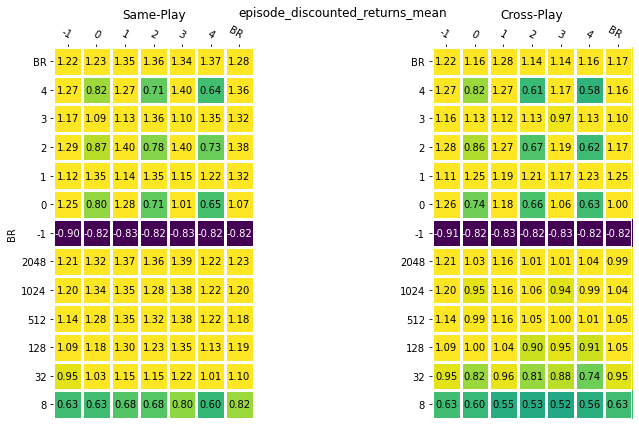

In [11]:
plot_ba_values_by_rollout_K(
    new_df, 
    y_key="episode_discounted_returns_mean", 
    include_rl_comparison=True, 
    plot_rl_df=rl_df,
    vrange=(-0.2, 1.0),
    figsize=(12, 6)
)
plt.show()

rollout_Ks=['BR']
coplayer_Ks=['-1', '0', '1', '2', '3', '4', 'BR']
row=0 rollout_K='BR'
num_sims=[8, 32, 128, 512, 1024, 2048]
coplayer_K=['-1', '0', '1', '2', '3', '4', 'BR']


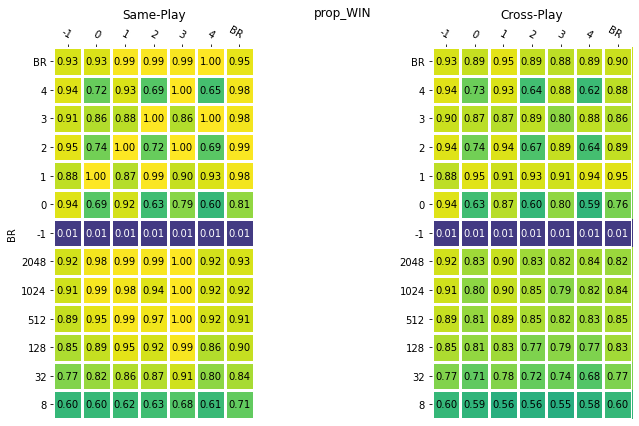

In [12]:
plot_ba_values_by_rollout_K(
    new_df, 
    y_key="prop_WIN", 
    include_rl_comparison=True, 
    plot_rl_df=rl_df,
    vrange=(-0.2, 1.0),
    figsize=(12, 6)
)
plt.show()

rollout_Ks=['BR']
coplayer_Ks=['-1', '0', '1', '2', '3', '4', 'BR']
row=0 rollout_K='BR'
num_sims=[8, 32, 128, 512, 1024, 2048]
coplayer_K=['-1', '0', '1', '2', '3', '4', 'BR']


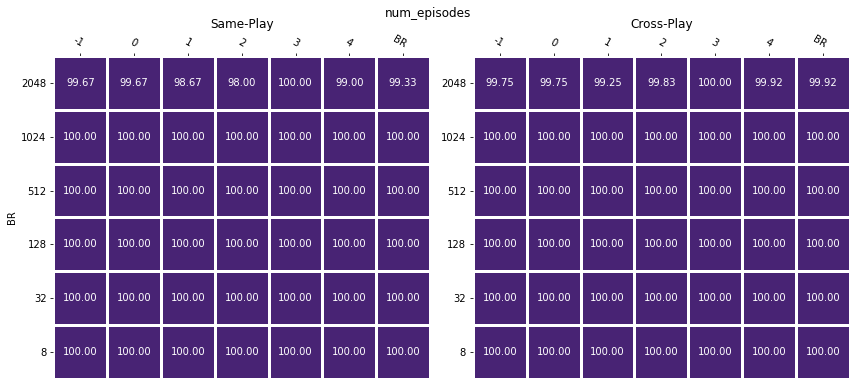

In [13]:
plot_ba_values_by_rollout_K(
    new_df, 
    y_key="num_episodes", 
    include_rl_comparison=False, 
    plot_rl_df=rl_df,
    vrange=(0, 1000),
    figsize=(12, 6)
)
plt.show()

rollout_Ks=['BR']
coplayer_Ks=['-1', '0', '1', '2', '3', '4', 'BR']
row=0 rollout_K='BR'
num_sims=[8, 32, 128, 512, 1024, 2048]
coplayer_K=['-1', '0', '1', '2', '3', '4', 'BR']


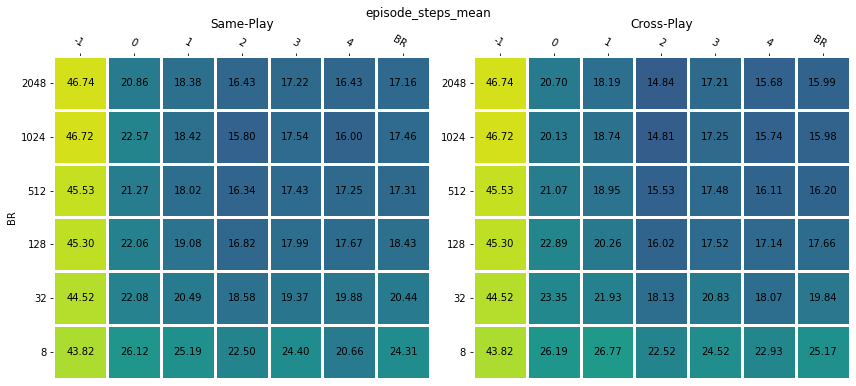

In [14]:
plot_ba_values_by_rollout_K(
    new_df, 
    y_key="episode_steps_mean", 
    include_rl_comparison=False, 
    plot_rl_df=rl_df,
    vrange=(0, 50),
    figsize=(12, 6)
)
plt.show()

rollout_Ks=['BR']
coplayer_Ks=['-1', '0', '1', '2', '3', '4', 'BR']
row=0 rollout_K='BR'
num_sims=[8, 32, 128, 512, 1024, 2048]
coplayer_K=['-1', '0', '1', '2', '3', '4', 'BR']


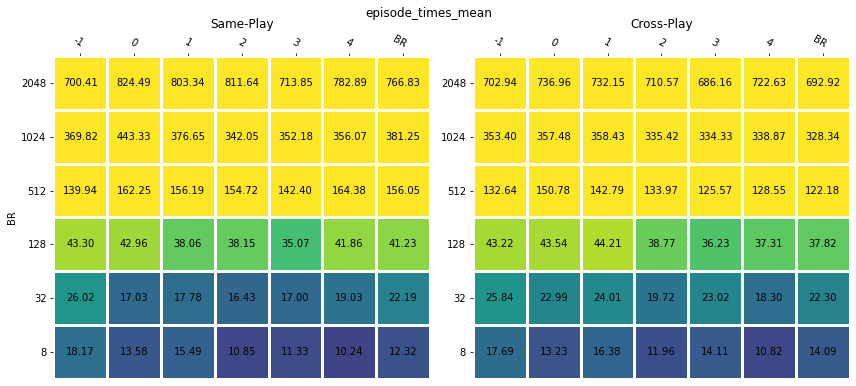

In [15]:
plot_ba_values_by_rollout_K(
    new_df, 
    y_key="episode_times_mean", 
    include_rl_comparison=False, 
    plot_rl_df=rl_df,
    vrange=(0, 50),
    figsize=(12, 6)
)
plt.show()

rollout_Ks=['BR']
coplayer_Ks=['-1', '0', '1', '2', '3', '4', 'BR']
row=0 rollout_K='BR'
num_sims=[8, 32, 128, 512, 1024, 2048]
coplayer_K=['-1', '0', '1', '2', '3', '4', 'BR']
num_sims=[8, 32, 128, 512, 1024, 2048]
coplayer_K=['-1', '0', '1', '2', '3', '4', 'BR']
  i=0 cp_K='-1'
  i=1 cp_K='0'
  i=2 cp_K='1'
  i=3 cp_K='2'
  i=4 cp_K='3'
  i=5 cp_K='4'
  i=6 cp_K='BR'


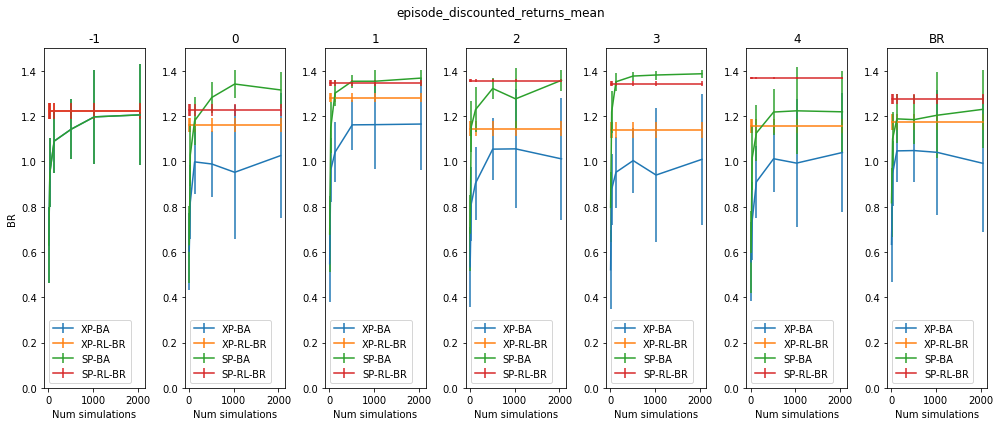

In [21]:
lineplot_ba_values(
    new_df, 
    y_key="episode_discounted_returns_mean",
    y_err_key="episode_discounted_returns_CI",
    rl_comparison_K=["BR"], 
    plot_rl_df=rl_df,
    vrange=(-0.0, 1.5),
    figsize=(14, 6)
)
plt.show()

# BA-NRMCP Beliefs Deeper dive

In the following plots we taker deeper dive into understanding the belief of BA-NRMCP.

For this analysis we restrict ourselves to a single experiment seed (100 episodes total). This is mainly for ease of analysis.

In [14]:
ba0_df = ba_df[ba_df["seed"] == 0]
plot_utils.validate_and_display(ba0_df, True)

# Result keys relating to agent beliefs
s_acc_key = "state_accuracy"
h_acc_key = "history_accuracy"
pi_distance_key = "action_dist_distance"
bayes_acc_key = "bayes_accuracy"

ba_agent_ids = ba_df[ba_df["K"] == "BA"]["agent_id"].unique()
assert len(ba_agent_ids) == 1, f"{ba_agent_ids=}"
ba_agent_id = ba_agent_ids[0]
cp_agent_id = (ba_agent_id + 1) % 2
print(f"{ba_agent_id=}")

step_limit = int(ba_df["step_limit"].unique()[0])
print(f"{step_limit=}")

num_seeds = len(ba_df["seed"].unique())

print()
for c in ba_df.columns:
    print(c)

Agent IDs: [0 1]
Test Env: Driving7x7RoundAbout-v0
Seeds: [0]
Policy K: ['-1' '0' '1' '2' '3' '4' 'BA' 'BR']
Policy Names: ['BAPOSGMCP_0' 'PPOPolicy_pi_0' 'PPOPolicy_pi_1' 'PPOPolicy_pi_2'
 'PPOPolicy_pi_3' 'PPOPolicy_pi_4' 'PPOPolicy_pi_BR' 'RandomPolicy']
Coplayer Policy K: ['-1' '0' '1' '2' '3' '4' 'BA' 'BR']
Coplayer Train Seed: [2 'None' 1 3 0 4]
Num rows/entries: 840
Num experiments: 420

BAPOSGMCP Hyperparameters
Num sims: ['128' '32' '512' '8']
Rollout Policy K: ['BR']
Rollout Policy IDs: ['pi_BR']
Rollout Policy Seeds: [0 1 3]
Rollout Policy Algs: ['klr']
Other Agent Policy Algs: ['klr']
Other Agent Policy Seeds: [0 1 3]
other_policy_prior: None
truncated: True
c_init: 1.25
c_base: 20000.0
reinvigorator: <baposgmcp.tree.reinvigorate.BABeliefRejectionSampler object at 0x7f202024d190> + other values
extra_particles_prop: 0.0625
step_limit: 50
epsilon: 0.01
ba_agent_id=0
step_limit=50

exp_id
agent_id
env_name
seed
num_episodes
policy_name
other_policy_prior
num_sims
c_init
c_bas

In [43]:
group_keys = [
    "agent_id", 
    "K",
    "num_sims", 
    "coplayer_K",
    "coplayer_train_seed",
    "coplayer_num_sims",
    "coplayer_other_seed",
    "train_seed", 
    "train_alg",
    "rollout_K", 
    "rollout_seed",
    "rollout_alg",
    "other_alg",
    "other_seed"
]

def CI(series):
    return 1.96 * np.std(series) / len(series)

ba_only_df = ba_df[ba_df["K"] == "BA"]

# CHANGE this to control the numsims and coplayer shown
ba_only_df = ba_only_df[(ba_only_df["coplayer_K"] == str(4)) & (ba_only_df["num_sims"] == str(512))]

groups = ba_only_df.groupby(group_keys)
ba_grouped_df = groups.agg([np.mean, np.std, CI]).reset_index()
ba_grouped_df.sort_values(["agent_id", "num_sims"], inplace=True)

print(ba_grouped_df)

/tmp/ipykernel_1141549/2994826728.py:26: FutureWarning: ['env_name', 'policy_name', 'other_policy_prior', 'c_init', 'c_base', 'truncated', 'reinvigorator', 'extra_particles_prop', 'step_limit', 'epsilon', 'policy_id', 'other_agent_policy_dir', 'other_agent_policy_ids', 'rollout_policy_ids', 'rollout_policy_dir', 'eval_mode', 'policy_dir', 'train_env_name', 'rollout_id'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  ba_grouped_df = groups.agg([np.mean, np.std, CI]).reset_index()


   agent_id   K num_sims coplayer_K coplayer_train_seed coplayer_num_sims  \
                                                                            
0         0  BA      512          4                   0              None   
1         0  BA      512          4                   0              None   
2         0  BA      512          4                   0              None   
3         0  BA      512          4                   1              None   
4         0  BA      512          4                   1              None   
5         0  BA      512          4                   1              None   
6         0  BA      512          4                   2              None   
7         0  BA      512          4                   2              None   
8         0  BA      512          4                   2              None   
9         0  BA      512          4                   3              None   
10        0  BA      512          4                   3              None   

In [30]:
def plot_stepwise_belief_stat(plot_df,
                              y_key: str,
                              ba_agent_id: int,
                              t_max: int,
                              is_cp_stat: bool,
                              y_lims=None):
    """Plot belief state (y_key) for each step."""
    
    def y_next_str(step_num):
        if is_cp_stat:
            return f"{y_key}_{cp_agent_id}_{step_num}"
        return f"{y_key}_{step_num}"
    
    ba_agent_seeds = plot_df["rollout_seed"].unique()
    ba_agent_seeds.sort()
    
    cp_agent_seeds = plot_df["coplayer_train_seed"].unique()
    cp_agent_seeds.sort()
    
    num_sims_all = plot_df["num_sims"].unique()
    num_sims_all = [int(n) for n in num_sims_all]
    num_sims_all.sort()
    
    xs = list(range(t_max))
    
    sp_df = plot_df[plot_df[["rollout_seed", "coplayer_train_seed"]].nunique(axis=1) == 1]
    xp_df = plot_df[plot_df[["rollout_seed", "coplayer_train_seed"]].nunique(axis=1) != 1]
    
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), squeeze=True)
    for num_sims in num_sims_all:
        for ax, ax_df in zip(axs, (sp_df, xp_df)):
            line_df = ax_df[ax_df["num_sims"] == str(num_sims)]

            ys = np.array([line_df[y_next_str(t)]["mean"].tolist()[0] for t in range(t_max)])
            ys_ci = np.array([line_df[y_next_str(t)]["CI"].tolist()[0] for t in range(t_max)])
        
            ax.plot(xs, ys, label=num_sims)
            ax.fill_between(xs, ys-ys_ci, ys+ys_ci)
            
    if y_lims is None:
        y_lims = (-0.00, 1.0)
    
    axs[0].set_ylabel(y_key)
    axs[0].set_xlabel("Step")
    axs[0].set_title("Same-Play")
    axs[0].set_ylim(y_lims)
    axs[0].legend()
    
    axs[1].set_ylabel(y_key)
    axs[1].set_xlabel("Step")
    axs[1].set_title("Cross-Play")
    axs[1].set_ylim(y_lims)
    
    fig.tight_layout()

[]

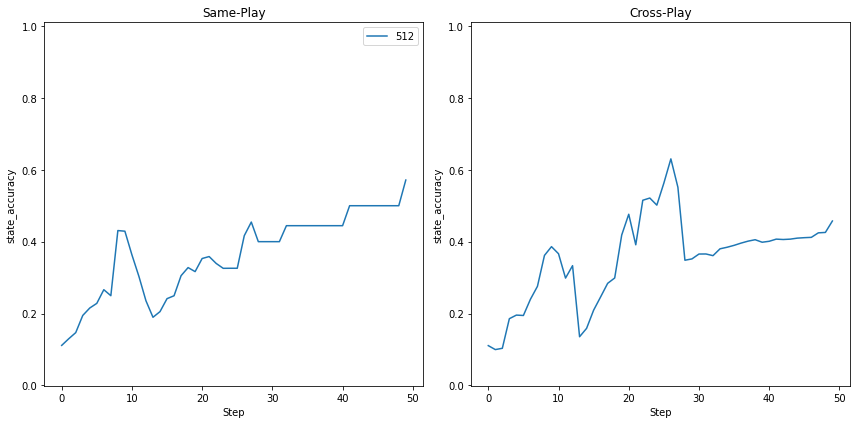

In [44]:
# Belief accuracy for the environment state
plot_stepwise_belief_stat(ba_grouped_df, s_acc_key, ba_agent_id, step_limit, False, y_lims=(-0.001, 1.01))
plt.plot()

[]

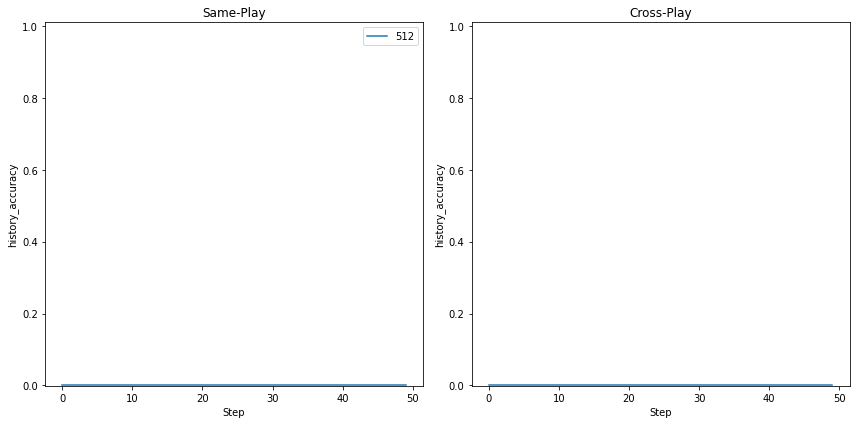

In [45]:
# Belief accuracy for the history of the other agent
plot_stepwise_belief_stat(ba_grouped_df, h_acc_key, ba_agent_id, step_limit, True,  y_lims=(-0.001, 1.01))
plt.plot()

[]

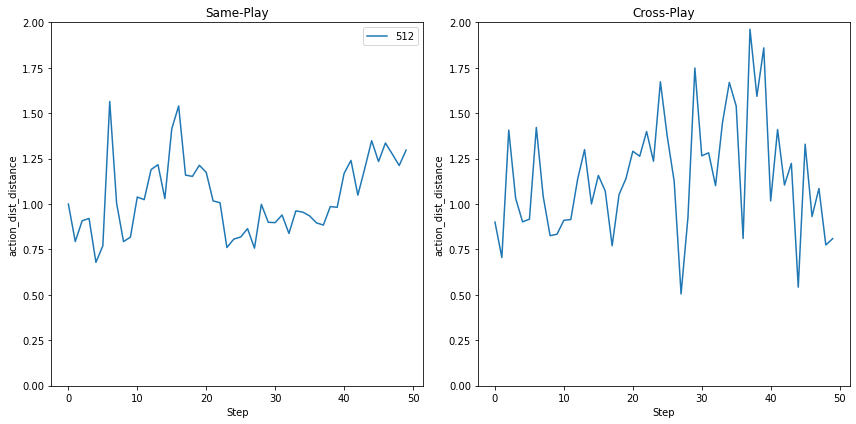

In [46]:
# Belief distance for the action of the other agent
plot_stepwise_belief_stat(ba_grouped_df, pi_distance_key, ba_agent_id, step_limit, True, y_lims=(-0.001, 2.0))
plt.plot()

[]

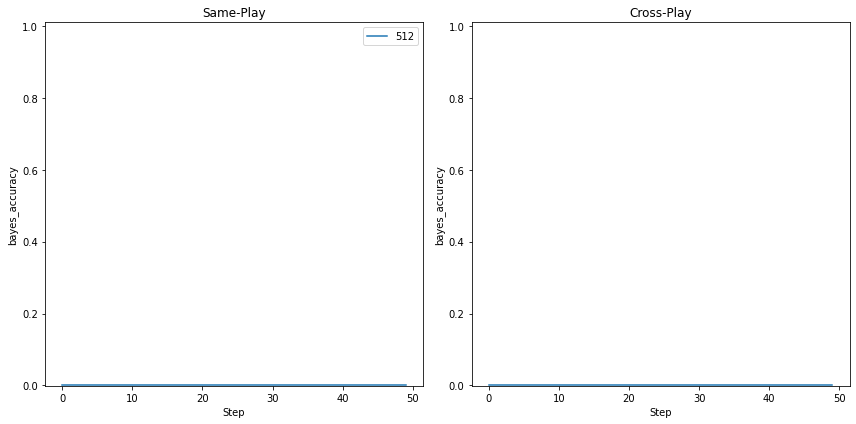

In [47]:
# Belief accuracy for the nesting level of the other agent
plot_stepwise_belief_stat(ba_grouped_df, bayes_acc_key, ba_agent_id, step_limit, True, y_lims=(-0.001, 1.01))
plt.plot()